In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-99fb6de3-9491-277e-dfd8-9458370609fb)


In [2]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-12 05:10:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-12 05:10:21 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

--2024-03-12 05:13:29--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.207, 108.177.111.207, 172.253.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2024-03-12 05:13:29 (144 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



Unzipping nlp_getting_started.zip gives the following 3 .csv files:

- sample_submission.csv - an example of the file you'd submit to the Kaggle competition of your model's predictions.
- train.csv - training samples of real and not real diaster Tweets.
- test.csv - testing samples of real and not real diaster Tweets.

Right now, our text data samples are in the form of .csv files. For an easy way to make them visual, let's turn them into pandas DataFrame's.

In [7]:
# Unzip data
!unzip "nlp_getting_started.zip"

Archive:  nlp_getting_started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [8]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [10]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...

---

Target: 0 (not real disaster)
Text:
@SonofBaldwin and he's the current Nova in the bookslast I checked..he was tied into the books in 2011 after Rider died during Annihilation

---

Target: 1 (real disaster)
Text:
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

---

Target: 0 (not real disaster)
Text:
Do you feel engulfed with low self-image? Take the quiz: http://t.co/YzDmouXQBO http://t.co/PeXfgawrG1

---

Target: 1 (real disaster)
Text:
Investigators shift focus to cause of fatal Waimate fire http://t.co/GoeTJGIhOp

---



Split data into training and validation sets

Since the test set has no labels and we need a way to evalaute our trained models, we'll split off some of the training data and create a validation set.

When our model trains (tries patterns in the Tweet samples), it'll only see data from the training set and we can see how it performs on unseen data using the validation set.

We'll convert our splits from pandas Series datatypes to lists of strings (for the text) and lists of ints (for the labels) for ease of use later.

To split our training dataset and create a validation dataset, we'll use Scikit-Learn's train_test_split() method and dedicate 10% of the training samples to the validation set.

In [13]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for rep

In [14]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In NLP, there are two main concepts for turning text into numbers:
- Tokenization - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
  1. Using word-level tokenization with the sentence "I love TensorFlow" might result in "I" being 0, "love" being 1 and "TensorFlow" being 2. In this case, every word in a sequence considered a single token.
  2. Character-level tokenization, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single token.
  3. Sub-word tokenization is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple tokens.
- Embeddings - An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:
  1. Create your own embedding - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.
  2. Reuse a pre-learned embedding - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [17]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [19]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
@Jake_ADavis @FaTality_US we are cuddling right now so.. ??      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 5668,   46,   22,    1,  179,   48,   28,    0,    0,    0,
           0,    0,    0,    0]])>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [23]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [25]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
. @VELDFest announces refunds after Day two's extreme weather evacuation: http://t.co/PP05eTlK7t http://t.co/3Ol8MhhPMa      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00724102,  0.02133952,  0.02230275, ...,  0.04850877,
         -0.02191699,  0.01905939],
        [ 0.03076487,  0.0325237 , -0.04175591, ...,  0.03664565,
         -0.03896986, -0.03206003],
        [-0.03725455, -0.03616063, -0.03570058, ..., -0.04922729,
         -0.02307752, -0.02300804],
        ...,
        [-0.01195715,  0.0206462 ,  0.04624427, ..., -0.02969795,
         -0.00818722,  0.01080407],
        [-0.01195715,  0.0206462 ,  0.04624427, ..., -0.02969795,
         -0.00818722,  0.01080407],
        [-0.01195715,  0.0206462 ,  0.04624427, ..., -0.02969795,
         -0.00818722,  0.01080407]]], dtype=float32)>

In [26]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.00724102,  0.02133952,  0.02230275, -0.02136731, -0.04978256,
        0.01584316,  0.0381659 , -0.03957377, -0.01479428, -0.00335339,
        0.03553453, -0.03955521,  0.01051077,  0.01990199, -0.02307396,
       -0.01991662, -0.0349967 ,  0.0223639 , -0.01573652,  0.01329238,
        0.04235042,  0.0402723 ,  0.01475142, -0.04212753, -0.03237607,
       -0.00486871, -0.00044029, -0.02895561,  0.01385453, -0.04080776,
        0.03258948, -0.00910227,  0.03522638,  0.0049065 ,  0.03789118,
       -0.02760073, -0.04743985,  0.00797055, -0.00487443,  0.04146386,
       -0.0101945 , -0.03472821,  0.02778052,  0.02095152,  0.04616803,
        0.02128848,  0.04951442, -0.0046206 , -0.01107363, -0.02855705,
       -0.01054436,  0.03135456, -0.00251972,  0.02379824,  0.03160978,
       -0.00762237,  0.0214991 ,  0.02333733, -0.02206538, -0.00552465,
        0.04720415,  0.03549272,  0.04228807, -0.00818165, -0.00809784,
       -0.013390

More specifically, we'll be building the following:

- Model 0: Naive Bayes (baseline)
- Model 1: Feed-forward neural network (dense model)
- Model 2: LSTM model
- Model 3: GRU model
- Model 4: Bidirectional-LSTM model
- Model 5: 1D Convolutional Neural Network
- Model 6: TensorFlow Hub Pretrained Feature Extractor
- Model 7: Same as model 6 with 10% of training data

## Model 0: Getting a baseline
As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the Multinomial Naive Bayes algorithm. This was chosen via referring to the Scikit-Learn machine learning map.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [29]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [31]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [32]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

#Model 1: A simple dense model

The first "deep" model we're going to build is a single layer dense model. In fact, it's barely going to have a single layer.

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

In [33]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [34]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [35]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [38]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240312-052036
Epoch 1/5
215/215 [==============================] - 13s 44ms/step - loss: 0.6089 - accuracy: 0.6935 - val_loss: 0.5361 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4409 - accuracy: 0.8196 - val_loss: 0.4694 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3462 - accuracy: 0.8602 - val_loss: 0.4593 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2847 - accuracy: 0.8921 - val_loss: 0.4644 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2379 - accuracy: 0.9123 - val_loss: 0.4770 - val_accuracy: 0.7861


In [39]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4770 - accuracy: 0.7861


[0.4770207703113556, 0.7860892415046692]

In [40]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00321282,  0.00613599,  0.03328704, ..., -0.04440014,
          0.00513072,  0.0266733 ],
        [-0.0293649 ,  0.02749453,  0.0141426 , ..., -0.0141356 ,
         -0.03238526,  0.00723128],
        [ 0.0592592 ,  0.00324697, -0.02714623, ...,  0.00574516,
         -0.00337024,  0.05320114],
        ...,
        [ 0.04274894,  0.00622487,  0.01037359, ...,  0.00921377,
          0.0101946 ,  0.04950663],
        [ 0.0491432 , -0.02791816, -0.08440161, ..., -0.0078818 ,
          0.05971676,  0.05799788],
        [ 0.03067774, -0.06287309, -0.0391704 , ..., -0.10860574,
          0.05645439,  0.08003506]], dtype=float32)>]

In [41]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [42]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 3ms/step


array([[0.41325864],
       [0.74415946],
       [0.9979006 ],
       [0.110792  ],
       [0.1073366 ],
       [0.93316215],
       [0.9113332 ],
       [0.9929181 ],
       [0.96862495],
       [0.2666713 ]], dtype=float32)

In [43]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [44]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [45]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [46]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


In [47]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [48]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [49]:
# Get the weight matrix of embedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


In [50]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [51]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [52]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [53]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


## Model 2: LSTM

Our model is going to take on a very similar structure to model_1:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

The main difference will be that we're going to add an LSTM layer between our embedding and output.

And to make sure we're not getting reusing trained embeddings (this would involve data leakage between models, leading to an uneven comparison later on), we'll create another embedding layer (model_2_embedding) for our model. The text_vectorizer layer can be reused since it doesn't get updated during training.

In [54]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

# Create LSTM Model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")


(None, 15, 128)
(None, 64)


In [56]:
#Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [58]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20240312-052345
Epoch 1/5
215/215 [==============================] - 10s 37ms/step - loss: 0.5110 - accuracy: 0.7432 - val_loss: 0.4549 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3170 - accuracy: 0.8714 - val_loss: 0.5140 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2195 - accuracy: 0.9156 - val_loss: 0.5848 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1546 - accuracy: 0.9451 - val_loss: 0.6024 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1073 - accuracy: 0.9600 - val_loss: 0.9023 - val_accuracy: 0.7598


In [59]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.00214329],
        [0.7530497 ],
        [0.9994635 ],
        [0.07314496],
        [0.00221869],
        [0.9994703 ],
        [0.91568315],
        [0.9997049 ],
        [0.9994437 ],
        [0.33541268]], dtype=float32))

In [60]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [61]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.98425196850394,
 'precision': 0.7604578907479682,
 'recall': 0.7598425196850394,
 'f1': 0.758116023760764}

In [62]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.98, Difference: -3.28
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


## Model 3: GRU
Another popular and effective RNN component is the GRU or gated recurrent unit. The GRU cell has similar features to an LSTM cell but has less parameters.

To use the GRU cell in TensorFlow, we can call the tensorflow.keras.layers.GRU() class. The architecture of the GRU-powered model will follow the same structure we've been using:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

Again, the only difference will be the layer(s) we use between the embedding and the output.

In [63]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [64]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [65]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [66]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20240312-052438
Epoch 1/5
215/215 [==============================] - 10s 35ms/step - loss: 0.5248 - accuracy: 0.7298 - val_loss: 0.4542 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3180 - accuracy: 0.8698 - val_loss: 0.4893 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2158 - accuracy: 0.9186 - val_loss: 0.5556 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1527 - accuracy: 0.9479 - val_loss: 0.6196 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1164 - accuracy: 0.9597 - val_loss: 0.5978 - val_accuracy: 0.7638


In [67]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.283744  ],
        [0.9118417 ],
        [0.99684393],
        [0.15811293],
        [0.01803667],
        [0.9896954 ],
        [0.7793236 ],
        [0.9955942 ],
        [0.99448025],
        [0.29444355]], dtype=float32))

In [68]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [69]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.37795275590551,
 'precision': 0.7634255198823986,
 'recall': 0.7637795275590551,
 'f1': 0.7630707606508437}

In [70]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.38, Difference: -2.89
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


##Model 4: Bidirectonal RNN model

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

Once again, TensorFlow helps us out by providing the tensorflow.keras.layers.Bidirectional class. We can use the Bidirectional class to wrap our existing RNNs, instantly making them bidirectional.

In [71]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [72]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [73]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [74]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20240312-052518
Epoch 1/5
215/215 [==============================] - 12s 35ms/step - loss: 0.5056 - accuracy: 0.7495 - val_loss: 0.4616 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3124 - accuracy: 0.8723 - val_loss: 0.5195 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2137 - accuracy: 0.9172 - val_loss: 0.5744 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1515 - accuracy: 0.9477 - val_loss: 0.6561 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1070 - accuracy: 0.9654 - val_loss: 0.6814 - val_accuracy: 0.7625


In [75]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.04329162],
       [0.87010235],
       [0.9993333 ],
       [0.16033937],
       [0.00490963],
       [0.9962674 ],
       [0.91840386],
       [0.99957377],
       [0.99957806],
       [0.35554114]], dtype=float32)

In [76]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [77]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.24671916010499,
 'precision': 0.7622420629158274,
 'recall': 0.7624671916010499,
 'f1': 0.7615230580020793}

In [78]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.25, Difference: -3.02
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


##Model 5: Conv1D

Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a temporal convolution) in action.

We'll first create an embedding of a sample of text and experiment passing it through a Conv1D() layer and GlobalMaxPool1D() layer.

In [79]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [80]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.04471499,  0.04223047, -0.02038503, ...,  0.03225725,
          -0.00401025, -0.01054098],
         [ 0.05269615, -0.07633816, -0.0457661 , ..., -0.07891267,
           0.06165894, -0.01105092],
         [ 0.05091388,  0.03406923, -0.02806908, ..., -0.02162672,
           0.04435388, -0.01968208],
         ...,
         [ 0.00321282,  0.00613599,  0.03328704, ..., -0.04440014,
           0.00513072,  0.0266733 ],
         [ 0.00321282,  0.00613599,  0.03328704, ..., -0.04440014,
           0.00513072,  0.0266733 ],
         [ 0.00321282,  0.00613599,  0.03328704, ..., -0.04440014,
           0.00513072,  0.0266733 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.02763679, 0.06202799, 0.03349356,
          0.07227747, 0.01204016, 0.05391983, 0.01015438, 0.        ,
          0.03255097, 0.        , 0.00292586, 0.01822909, 0.03109275,
          0.        , 0.

In [81]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [82]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240312-052600
Epoch 1/5
215/215 [==============================] - 9s 34ms/step - loss: 0.5667 - accuracy: 0.7119 - val_loss: 0.4708 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3399 - accuracy: 0.8618 - val_loss: 0.4724 - val_accuracy: 0.7966
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2108 - accuracy: 0.9231 - val_loss: 0.5308 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1348 - accuracy: 0.9556 - val_loss: 0.6072 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0926 - accuracy: 0.9701 - val_loss: 0.6602 - val_accuracy: 0.7874


In [83]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.85715723],
       [0.69435245],
       [0.9990447 ],
       [0.05305431],
       [0.00166566],
       [0.9965663 ],
       [0.9190347 ],
       [0.99800056],
       [0.99933225],
       [0.14211169]], dtype=float32)

In [84]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [85]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 78.74015748031496,
 'precision': 0.7897494631352898,
 'recall': 0.7874015748031497,
 'f1': 0.7853521734440729}

In [86]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 78.74015748031496,
 'precision': 0.7897494631352898,
 'recall': 0.7874015748031497,
 'f1': 0.7853521734440729}

In [87]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.79, Difference: -0.00


#Using Pretrained Embeddings (transfer learning for NLP)
For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through transfer learning. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the Universal Sentence Encoder from TensorFlow Hub (a great resource containing a plethora of pretrained model resources for a variety of tasks).

##Model 6: TensorFlow Hub Pretrained Sentence Encoder
The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.



In [88]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [89]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [90]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [91]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [92]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240312-052809
Epoch 1/5
215/215 [==============================] - 6s 17ms/step - loss: 0.5041 - accuracy: 0.7886 - val_loss: 0.4478 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4144 - accuracy: 0.8139 - val_loss: 0.4361 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3997 - accuracy: 0.8221 - val_loss: 0.4321 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3923 - accuracy: 0.8262 - val_loss: 0.4277 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3861 - accuracy: 0.8300 - val_loss: 0.4293 - val_accuracy: 0.8150


In [93]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 2s 26ms/step


array([[0.15740962],
       [0.74801457],
       [0.986684  ],
       [0.19113225],
       [0.7446095 ],
       [0.69765514],
       [0.98178023],
       [0.97783184],
       [0.92853785],
       [0.09490162]], dtype=float32)

In [94]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [95]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8179063565195398,
 'recall': 0.8149606299212598,
 'f1': 0.8132300658103407}

In [96]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.50, Difference: 2.23
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03


##Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data
One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [97]:
### NOTE: Making splits like this will lead to data leakage ###
### (some of the training examples in the validation set) ###

### WRONG WAY TO MAKE SPLITS (train_df_shuffled has already been split) ###

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [99]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,)


In [100]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [101]:
# Check the number of targets in our subset of data
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    404
1    282
dtype: int64

In [102]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [103]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20240312-052947
Epoch 1/5
22/22 [==============================] - 3s 41ms/step - loss: 0.6717 - accuracy: 0.7012 - val_loss: 0.6449 - val_accuracy: 0.7717
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.6010 - accuracy: 0.8149 - val_loss: 0.5815 - val_accuracy: 0.7717
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5259 - accuracy: 0.8207 - val_loss: 0.5259 - val_accuracy: 0.7808
Epoch 4/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4648 - accuracy: 0.8353 - val_loss: 0.4918 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4215 - accuracy: 0.8397 - val_loss: 0.4737 - val_accuracy: 0.7769


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

In [108]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [110]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.69028871391076,
 'precision': 0.7772431692902212,
 'recall': 0.7769028871391076,
 'f1': 0.7756776970544694}

In [111]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.69, Difference: -1.57
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


##Comparing the performance of each of our models
Woah. We've come a long way! From training a baseline to several deep models.

Now it's time to compare our model's results.

But just before we do, it's worthwhile mentioning, this type of practice is a standard deep learning workflow. Training various different models, then comparing them to see which one performed best and continuing to train it if necessary.

The important thing to note is that for all of our modelling experiments we used the same training data (except for model_7 where we used 10% of the training data).

To visualize our model's performances, let's create a pandas DataFrame we our results dictionaries and then plot it.

In [112]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,75.984252,0.760458,0.759843,0.758116
gru,76.377953,0.763426,0.763780,0.763071
bidirectional,76.246719,0.762242,0.762467,0.761523
conv1d,78.740157,0.789749,0.787402,0.785352
tf_hub_sentence_encoder,81.496063,0.817906,0.814961,0.813230
tf_hub_10_percent_data,77.690289,0.777243,0.776903,0.775678


In [113]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

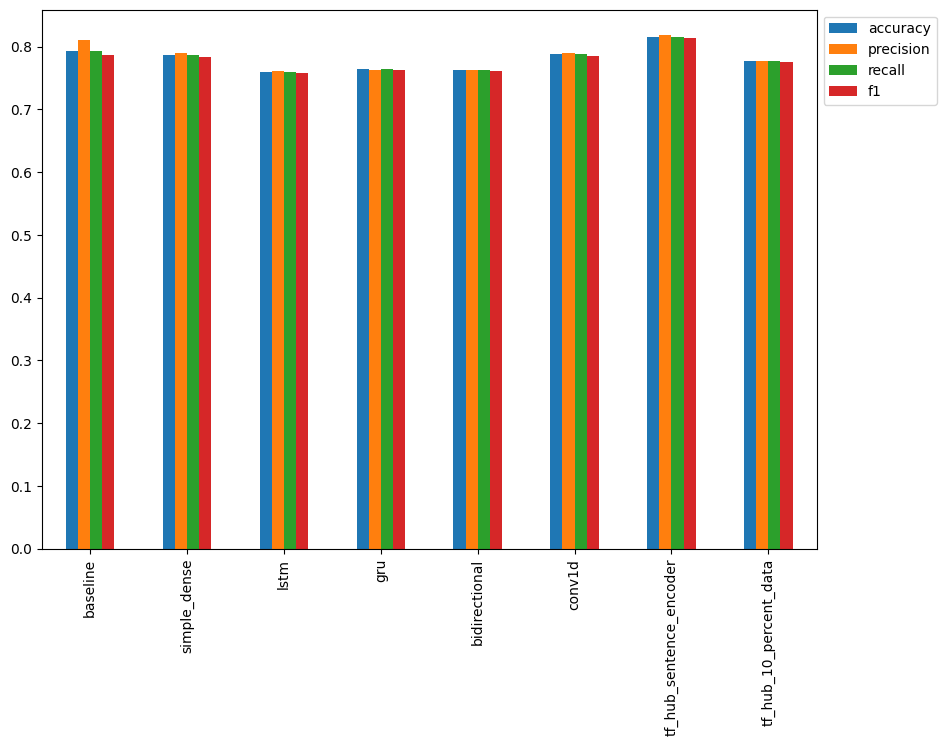

In [114]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

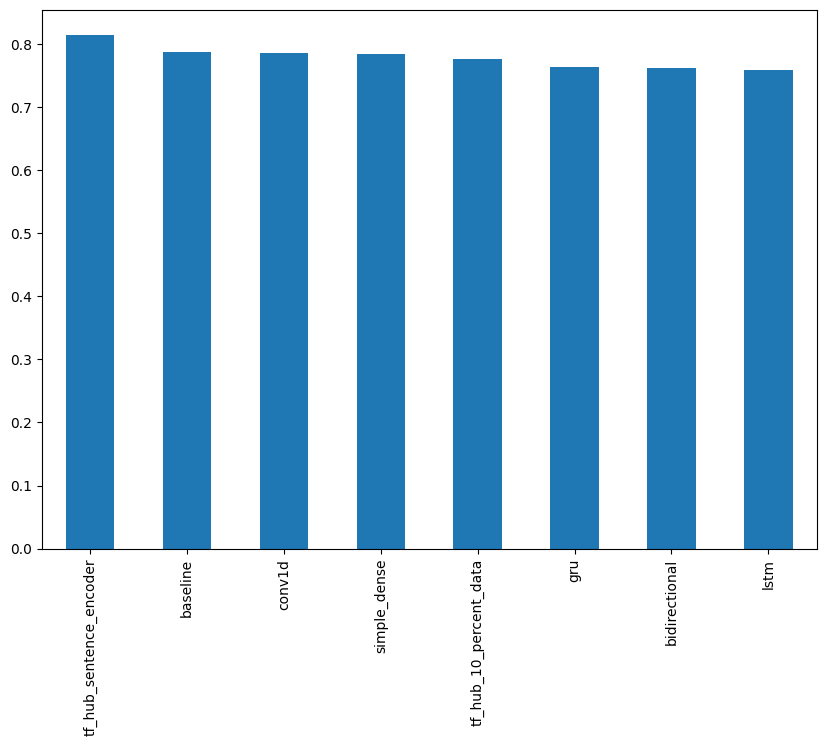

In [115]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

##Combining our models (model ensembling/stacking)
Many production systems use an ensemble (multiple different models combined) of models to make a prediction.

The idea behind model stacking is that if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by a singular model.

The keyword in the sentence above is uncorrelated, which is another way of saying, different types of models. For example, in our case, we might combine our baseline, our bidirectional model and our TensorFlow Hub USE model.

Although these models are all trained on the same data, they all have a different way of finding patterns.

If we were to use three similarly trained models, such as three LSTM models, the predictions they output will likely be very similar.

Think of it as trying to decide where to eat with your friends. If you all have similar tastes, you'll probably all pick the same restaurant. But if you've all got different tastes and still end up picking the same restaurant, the restaurant must be good.

Since we're working with a classification problem, there are a few of ways we can combine our models:

1. Averaging - Take the output prediction probabilities of each model for each sample, combine them and then average them.
2. Majority vote (mode) - Make class predictions with each of your models on all samples, the predicted class is the one in majority. For example, if three different models predict [1, 0, 1] respectively, the majority class is 1, therefore, that would be the predicted label.
3. Model stacking - Take the outputs of each of your chosen models and use them as inputs to another model.

In [116]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [117]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.34645669291339,
 'precision': 0.7831873004154389,
 'recall': 0.7834645669291339,
 'f1': 0.782932054801025}

In [118]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [119]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [120]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.790328,0.786089,0.783297
lstm,0.759843,0.760458,0.759843,0.758116
gru,0.763780,0.763426,0.763780,0.763071
bidirectional,0.762467,0.762242,0.762467,0.761523
conv1d,0.787402,0.789749,0.787402,0.785352
tf_hub_sentence_encoder,0.814961,0.817906,0.814961,0.813230
tf_hub_10_percent_data,0.776903,0.777243,0.776903,0.775678
ensemble_results,0.783465,0.783187,0.783465,0.782932


##Saving and loading a trained model
Although training time didn't take very long, it's good practice to save your trained models to avoid having to retrain them.

Saving your models also enables you to export them for use elsewhere outside of your notebooks, such as in a web application.

There are two main ways of saving a model in TensorFlow:

The HDF5 format.
The SavedModel format (default).

In [121]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [122]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [123]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4293 - accuracy: 0.8150


[0.4292505085468292, 0.8149606585502625]

In [124]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [125]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [126]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4293 - accuracy: 0.8150


[0.4292505085468292, 0.8149606585502625]

##Finding the most wrong examples

We mentioned before that if many of our modelling experiments are returning similar results, despite using different kinds of models, it's a good idea to return to the data and inspect why this might be.

One of the best ways to inspect your data is to sort your model's predictions and find the samples it got most wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

Once again, visualization is your friend. Visualize, visualize, visualize.

To make things visual, let's take our best performing model's prediction probabilities and classes along with the validation samples (text and ground truth labels) and combine them in a pandas DataFrame.

If our best model still isn't perfect, what examples is it getting wrong?
Which ones are the most wrong?
Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [127]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.157410
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.748015
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.986684
3,@camilacabello97 Internally and externally scr...,1,0.0,0.191132
4,Radiation emergency #preparedness starts with ...,1,1.0,0.744609


In [128]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.915470
759,FedEx will no longer transport bioterror patho...,0,1.0,0.873118
628,@noah_anyname That's where the concentration c...,0,1.0,0.854167
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.847660
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.834625
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.816159
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.792174
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.787016
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.780721
695,A look at state actions a year after Ferguson'...,0,1.0,0.778260


In [129]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9154703617095947
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8731176853179932
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8541666269302368
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8476603627204895
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8346248865127563
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8161594271659851
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1, Prob: 0.792174100

In [130]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06125352159142494
Text:
Next May I'll be free...from school from obligations like family.... Best of all that damn curfew...

----

Target: 1, Pred: 0, Prob: 0.06013859063386917
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.057701170444488525
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.0546422079205513
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.0545792318880558
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.04273809492588043
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0

##Making predictions on the test dataset
Alright we've seen how our model's perform on the validation set.

But how about the test dataset?

We don't have labels for the test dataset so we're going to have to make some predictions and inspect them for ourselves.

Let's write some code to make predictions on random samples from the test dataset and visualize them.

In [131]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 39ms/step
Pred: 0, Prob: 0.3655015528202057
Text:
THE CHEMICAL BROTHERS to play The Armory in SF tomorrow night!: EMERGENCY BAY AREA EDM ANNOUNCEMENT ÛÒ THE CHEM... http://t.co/Uhgx7uQoBd

----

1/1 [==============================] - 0s 35ms/step
Pred: 0, Prob: 0.3784736394882202
Text:
@kdudakia I get that there has been a massive turn away from Labour but that does not = electoral landslide. Credits tories too much and...

----

1/1 [==============================] - 0s 34ms/step
Pred: 0, Prob: 0.13620246946811676
Text:
He's about to leave on a stretcher.

----

1/1 [==============================] - 0s 35ms/step
Pred: 0, Prob: 0.14023315906524658
Text:
Society has become so engulfed in capturing every moments and sharing it  it takes the fun out of moments that should be intimate.

----

1/1 [==============================] - 0s 35ms/step
Pred: 0, Prob: 0.021386483684182167
Text:
The Devil Wears Prada is still one of my favourite films ??

-

##Predicting on Tweets from the wild
How about we find some Tweets and use our model to predict whether or not they're about a diaster or not?

To start, let's take one of my own Tweets on living life like an ensemble model.

In [132]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [133]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [134]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 54ms/step
Pred: 0.0 (not real disaster) Prob: 0.044311754405498505
Text:
Life like an ensemble: take the best choices from others and make your own


In [135]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [136]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 36ms/step
Pred: 1.0 (real disaster) Prob: 0.9651009440422058
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [137]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 37ms/step
Pred: 1.0 (real disaster) Prob: 0.9746817350387573
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


##The speed/score tradeoff
One of the final tests we're going to do is to find the speed/score tradeoffs between our best model and baseline model.

Why is this important?

Although it can be tempting to just choose the best performing model you find through experimentation, this model might not actually work in a production setting.

Put it this way, imagine you're Twitter and receive 1 million Tweets per hour (this is a made up number, the actual number is much higher). And you're trying to build a diaster detection system to read Tweets and alert authorities with details about a diaster in close to real-time.

Compute power isn't free so you're limited to a single compute machine for the project. On that machine, one of your models makes 10,000 predictions per second at 80% accuracy where as another one of your models (a larger model) makes 100 predictions per second at 85% accuracy.

Which model do you choose?

Is the second model's performance boost worth missing out on the extra capacity?

Of course, there are many options you could try here, such as sending as many Tweets as possible to the first model and then sending the ones which the model is least certain of to the second model.

The point here is to illustrate the best model you find through experimentation, might not be the model you end up using in production.

To make this more concrete, let's write a function to take a model and a number of samples and time how long the given model takes to make predictions on those samples.

In [138]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [139]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 9ms/step


(0.3571292720000656, 0.0004686735853019234)

In [140]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.024663734000114346, 3.23671049870267e-05)

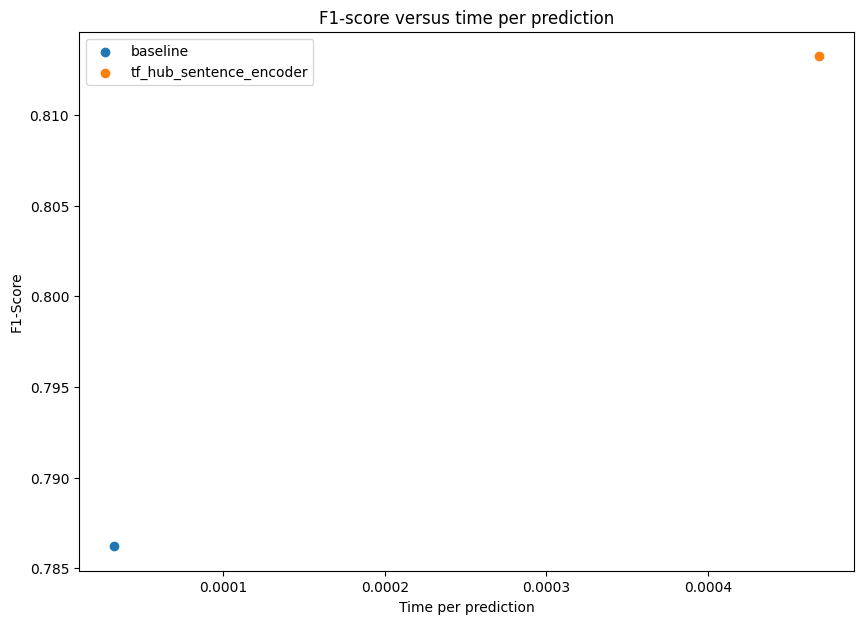

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");